In [4]:
# %%capture
# !pip install langgraph langchain langchain_openai langchain_community

In [35]:
# Import
import os
import sys

# Change to the project root directory
os.chdir('/home/alaa/repos/seez-assignment')
current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.insert(0, current_dir)

try:
    from src.utils.tools import read_dialogue
    print("Import successful!")
except:
    print("Failed")

import os

from src.api_key import OPENAI_API_KEY

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

Import successful!


In [24]:
from typing import Annotated, Dict
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    completed_nodes: Annotated[list[str], lambda x, y: list(set(x + y))]
    active_nodes: list[bool]
    latest_router_decision: str
    user_context: Dict = {}
    similarities: Dict = {}

In [3]:
from typing import List, Callable, Dict, Any

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

model_name = "gpt-4o"

class AssistantNode:
    def __init__(
            self, 
            name: str, system_prompt: str, 
            tools: List[Callable] = [], 
            completion_tool: str = "", 
            llm_chain: Runnable = None,
            model_name=model_name
            ) -> None:
        """
        completion_tool: Is the tool binded to the node and once it is triggered, this
        node is assigned as completed, and this node name 'name' is appended to the State
        completed_node variable.
        """
        self.name = name
        self.system_prompt = system_prompt
        self.tools = tools
        self.completion_tool = completion_tool
        self.llm = llm_chain or ChatOpenAI(model=model_name)

    def update_system_prompt(self, prompt_config: dict) -> str:
        # self.logger.debug(f"Updating system prompt for {self.name}...")
        print(f"Updating system prompt for {self.name}...")
        try:
            if prompt_config and isinstance(prompt_config, dict):
                formatted_prompt = self.system_prompt.format_map(prompt_config)
                # self.logger.info(f"Using prompt config for {self.name}")
                print(f"Using prompt config for {self.name}")
            else:
                formatted_prompt = self.system_prompt
                # self.logger.info(f"Using default prompt for {self.name},no prompt configs!")
                print(f"Using default prompt for {self.name},no prompt configs!")
        except KeyError as e:
            formatted_prompt = self.system_prompt
            print(f"Error formatting prompt for {self.name}: {e}")
            # self.logger.error(f"Error formatting prompt for {self.name}: {e}")
        return formatted_prompt

    def __call__(self, state: State, config: RunnableConfig) -> Dict[str, Any]:

        print(f"Current Node: {self.name.title()}\n")

        system_prompt = self.update_system_prompt(
            {**state["company_profile"], **state["user_context"], **state["session_data"]}
        )
        assistant_prompt = ChatPromptTemplate.from_messages([("system", system_prompt),("placeholder", "{messages}")])
        if self.tools:
            llm_chain = assistant_prompt | self.llm.bind_tools(self.tools)
        else:
            llm_chain = assistant_prompt | self.llm

        while True:
            response = llm_chain.invoke(state)
            # print(response)
            if not response.tool_calls and (
                not response.content
                or isinstance(response.content, list)
                and not response.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Your last response was empty. Please provide a correct response.")]
                state = {**state, "messages": messages}
            else:
                break

        return {"messages": response}

In [27]:
from src.utils.tools import read_dialogue, read_user_data, read_jsonl, read_json, get_conversation_by_id
path = 'data/Movie'
final_data_path = '{}/final_data.jsonl'.format(path)
Conversation_path = '{}/Conversation.txt'.format(path)
user_map_path = '{}/user_ids.json'.format(path)
item_map_path = '{}/item_map.json'.format(path)

final_data = read_jsonl(final_data_path)
item_map = read_json(item_map_path)
user_map = read_json(user_map_path)
Conversation = read_dialogue(Conversation_path)

In [32]:
import random

def fetch_user_information(
    state, 
    config
):
    print(); print("Current Node: Fetch User Info")
    configuration = config.get("configurable", {})
    user_id = configuration.get("user_id", None)

    user_data = {}
    
    if not user_id:
        return {
            "user_context": {
                "user_data": user_data, 
                "user_exists": False,
            },
            "similarities": {}
        }
    
    try:
        from src.utils.tools import read_dialogue, read_user_data, read_jsonl, read_json, get_conversation_by_id

        path = 'data/Movie'
        final_data_path = '{}/final_data.jsonl'.format(path)
        Conversation_path = '{}/Conversation.txt'.format(path)
        user_map_path = '{}/user_ids.json'.format(path)
        item_map_path = '{}/item_map.json'.format(path)
        
        final_data = read_jsonl(final_data_path)
        item_map = read_json(item_map_path)
        user_map = read_json(user_map_path)
        Conversation = read_dialogue(Conversation_path)

        if user_id in user_map:
            user_information = read_user_data(final_data_path, user_id)
            history_interaction = user_information['history_interaction']
            user_might_likes = user_information['user_might_like']
        
            user_data = {
                    "history_interaction": [item_map[history_interaction[k]] for k in range(len(history_interaction))],
                    "user_might_like": [item_map[user_might_likes[k]] for k in range(len(user_might_likes))],
                    "Conversation": {}
                }
            Conversation_info = user_information['Conversation']
            for j in range(len(Conversation_info)):
                per_conversation_info = Conversation_info[j]['conversation_{}'.format(j + 1)]
                user_likes_id = per_conversation_info['user_likes']
                user_dislikes_id = per_conversation_info['user_dislikes']
                rec_item_id = per_conversation_info['rec_item']
                conversation_id = per_conversation_info['conversation_id']
                dialogue = get_conversation_by_id(Conversation, conversation_id)
                user_data['Conversation']["conversation_{}".format(j + 1)] = {
                    "user_likes": [item_map[user_likes_id[k]] for k in range(len(user_likes_id))],
                    "user_dislikes": [item_map[user_dislikes_id[k]] for k in range(len(user_dislikes_id))],
                    "rec_item": [item_map[rec_item_id[k]] for k in range(len(rec_item_id))],
                    "conversation_id": conversation_id,
                    "dialogue": dialogue
                    }
        
            return {
                "user_context": {
                    "user_data": user_data, 
                    "user_exists": True,
                },
                "similarities": {}
            }

        return {
            "user_context": {
                "user_data": user_data, 
                "user_exists": False,
            },
            "similarities": {}
        }

    except Exception as e:
        print(e)
        return {
            "user_context": {
                "user_data": user_data, 
                "user_exists": False,
            },
            "similarities": {}
        }
    

In [33]:
from datetime import datetime

def init_session_state(
    state,
    config
):
    print(); print("Current Node: Init Session State")

    return {
        "session_data": {
            "date": datetime.now().strftime("%A, %B %d, %Y"),
            "time": datetime.now().strftime("%H:%M:%S")
        },
        "user_context": {
            "user_data": user_data, 
            "user_exists": False,
        },
        "similarities": {}
    }

In [34]:
import uuid

state = State()
config = config = {
        "configurable": {
            "thread_id": str(uuid.uuid4()),
            "user_id": "A30Q8X8B1S3GGT"
        }
    }

state_ = fetch_user_information(state, config)


Current Node: Fetch User Info


In [8]:
# state_

In [9]:
import pandas as pd
from typing import List, Union
from langchain_core.tools import tool

@tool
def get_recommendations(collected_info: str) -> list[dict]:
    """
    Get movie recommendations based on collected user preferences.
    
    Args:
        collected_info (str): Concise summary of user preferences from follow-up agent
            Example: "User is looking for intense psychological thrillers like Inception and Shutter Island, prefer modern movies with complex plots"
    
    Returns:
        list[str]: List of recommended movies
    """
    
    # similar_movies = similarity_search.search(
    #     query_text=collected_info,
    #     k=top_k
    # )
    
    # # Format results with basic filtering
    # recommendations = []
    # seen_titles = set()
    
    # for movie in similar_movies:
    #     # Avoid duplicate titles
    #     if movie['title'] not in seen_titles:
    #         recommendations.append({
    #             'movie_id': movie['id'],
    #             'title': movie['title'],
    #             'similarity_score': movie['score'],
    #             'reasoning': movie['explanation']
    #         })
    #         seen_titles.add(movie['title'])
            
    #     # Break if we have enough recommendations
    #     if len(recommendations) >= top_k:
    #         break
            
    return "recommendations"

In [36]:
recommender_old_prompt = """You are a movie recommendation assistant. Your task is to provide personalized movie recommendations based on `user might like` and user's queries.

Task:
1. Understand the user's query
2. Consider their watch history and previous feedback
3. Recommend movies through the conversation until user is satisfied
4. Briefly explain why each recommendation matches their interests

Do not:
- Recommend movies already in user's history or disliked
- Provide lengthy movie descriptions

Context Format:
- User might like (Movies for main recommendation): {user_might_like}
- Conversations (dialogue examples): {dialogue}
"""

recommender_new_prompt = """You are a movie recommendation assistant. Your task is to provide personalized movie recommendations based on provided context.

Task:
1. Understand the user's current movie preferences
2. Recommend movies through the conversation until user is satisfied
3. Briefly explain why each recommendation matches their interests

Do not:
- Recommend movies already in user's history or disliked
- Provide lengthy movie descriptions

Context Format:
- User might like (Movies for main recommendation): {user_might_like}
- Conversations (dialogue examples): {dialogue}
"""

follow_up_prompt = """"You are a focused follow-up agent for a movie recommendation system. Your role is to quickly gather essential preferences when the initial query lacks sufficient information, then trigger the recommendation tool with a concise preference summary.

Task:
1. Gather critical user preferences through minimal, targeted questions (1-2 exchanges maximum)
2. Construct a brief preference summary
3. Trigger the recommendation tool with the collected information

Essential Information to Gather (prioritized):
1. Favorite movies/examples OR specific genres
2. Mood/tone preference (if not clear from examples)
3. Time period preference (only if relevant)

Question Templates:
1. For no context:
"Could you tell me a movie you've enjoyed recently, or what type of movie you're in the mood for? (e.g., fun comedy, intense thriller)"

2. For vague mood:
"Would you prefer something [mood_a] like [example_movie_a] or [mood_b] like [example_movie_b]?"

3. For general requests:
"What kind of movies do you usually enjoy? You can mention a favorite movie or genre."

Tool Triggering:
Once sufficient information is gathered, create a BRIEF summary to get similars based on it.
```

Remember:
- Collect only essential information
- Use at most 2 turns of conversation
- Create concise summary for tool
- Don't make recommendations yourself
- Stop collecting once you have enough information
"""

router_prompt = """
You are a conversation router for a movie recommendation system. Your task is to analyze user conversation and determine whether they contain sufficient information for making recommendations or require follow-up questions to clarify preferences. Assign only ONE assistant per message; do NOT delegate multiple assistants.

Task:
Analyze the user query and context to determine:
1. If the query contains enough specific information for direct recommendations
2. If follow-up questions are needed to gather more precise preferences

Decision Criteria:
Route to `recommender` if query has:
- Specific movie references (e.g., "like Star Wars")
- Clear genre preferences (e.g., "action movies")
- Explicit attributes (e.g., "80s comedies")
- Actor/Director preferences (e.g., "movies with Tom Hanks")
- Mood/Theme specifications (e.g., "something suspenseful")

Route to follow_up if query:
- Is too general (e.g., "recommend a movie")
- Contains ambiguous terms
- Needs preference clarification
- Has multiple possible interpretations

"""
# Recommender Agent for old users
recommender_old_node = AssistantNode(
    name="recommender_old", 
    system_prompt=recommender_old_prompt, 
)

# Recommender Agent for new users
recommender_new_node = AssistantNode(
    name="recommender_new", 
    system_prompt=recommender_new_prompt, 
)

# Follo-up Agent
follow_up_tools = [get_recommendations]
follow_up_node = AssistantNode(
    name="follow_up", 
    system_prompt=follow_up_prompt, 
    tools=follow_up_tools,
    completion_tool="get_recommendations"
)

# Follo-up Agent
router_node = AssistantNode(
    name="router", 
    system_prompt=router_prompt, 
)

In [12]:
from langchain_core.runnables import RunnableLambda
from langgraph.prebuilt import ToolNode

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], 
        exception_key="error"
    )

In [40]:
from langgraph.graph import END
from langgraph.prebuilt import tools_condition

# Routing Functions
def start_decision(state: State):
    if len(state["messages"]) == 1:
        return "init_session_state"
    elif "follow_up" in state["active_nodes"]:
        return "follow_up"
    return "router"

def fetch_user_info_decision(state):
    if state["user_context"]["user_exists"]:
        return "recommender_new"
    return "router"

def router_decision(state: State):
    if state["latest_router_decision"] == "follow_up":
        return "follow_up"
    elif state["user_context"]["user_exists"]:
        return "recommender_old"
    return "recommender_new"

def similarity_search_decision(state: State):
    route = tools_condition(state)
    if route == END:
        return END
    elif state["user_context"]["user_exists"]:
        return "recommender_old"
    return "recommender_new"

def follow_up_decision(state: State):
    route = tools_condition(state)
    if route == END:
        if state["user_context"]["user_exists"]:
            return "recommender_old"
        else: 
            return "recommender_new"
    return "follow_up_tools"

In [41]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(State)

# Add nodes
workflow.add_node("init_session_state", init_session_state)
workflow.add_node("fetch_user_information", fetch_user_information)


workflow.add_node("router", router_node)
workflow.add_node("follow_up", follow_up_node)
workflow.add_node("follow_up_tools", create_tool_node_with_fallback(follow_up_tools))
workflow.add_node("recommender_old", recommender_old_node)
workflow.add_node("recommender_new", recommender_new_node)

# Add edges 
workflow.add_conditional_edges(
    START, 
    start_decision, 
    ["init_session_state", "follow_up", "router"]
)

workflow.add_edge("init_session_state", "fetch_user_information")
workflow.add_conditional_edges(
    "fetch_user_information",
    fetch_user_info_decision,
    ["recommender_new", "router"])

workflow.add_conditional_edges(
    "router",
    router_decision,
    ["follow_up", "recommender_old", "recommender_new"],
)

workflow.add_edge("recommender_old", END)
workflow.add_edge("recommender_new", END)

workflow.add_edge("follow_up_tools", "follow_up")
workflow.add_conditional_edges(
    "follow_up",
    follow_up_decision, 
    ["recommender_old", "recommender_new", "follow_up_tools", END]
)

# Compile the graph
checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

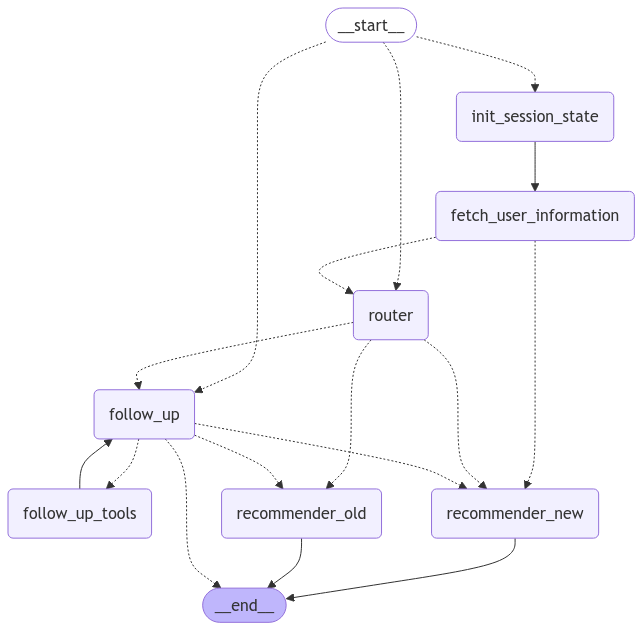

In [42]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))